In [1]:
import cv2
import os
import numpy as np
import pandas as pd
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import time
import logging

## Imputation
from sklearn.impute import SimpleImputer, KNNImputer

## Feature-scaling stack
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, OneHotEncoder, FunctionTransformer

## Dimesionality reduction
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif

## Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.combine import SMOTEENN

## Machine-learning stack
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier, AdaBoostClassifier 
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

## Metrics
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, roc_curve, roc_auc_score, auc, fbeta_score, f1_score

## Model saving
from joblib import dump, load

import warnings
warnings.filterwarnings('ignore')

# Evaluation Functions

In [2]:
def partial_auc_score(y_actual, y_scores, tpr_threshold=0.80):
    max_fpr = 1 - tpr_threshold

    # create numpy arrays
    y_actual = np.asarray(y_actual)
    y_scores = np.asarray(y_scores)

    # ROC curve
    fpr, tpr, _ = roc_curve(y_actual, y_scores)

    # Find the index where fpr exceeds max_fpr
    stop_index = np.searchsorted(fpr, max_fpr, side='right')

    if stop_index < len(fpr):
        # Interpolate to find the TPR at max_fpr
        fpr_interp_points = [fpr[stop_index - 1], fpr[stop_index]]
        tpr_interp_points = [tpr[stop_index - 1], tpr[stop_index]]
        tpr = np.append(tpr[:stop_index], np.interp(max_fpr, fpr_interp_points, tpr_interp_points))
        fpr = np.append(fpr[:stop_index], max_fpr)
    else:
        tpr = np.append(tpr, 1.0)
        fpr = np.append(fpr, max_fpr)

    # Calculate partial AUC
    partial_auc_value = auc(fpr, tpr)

    return partial_auc_value
    
def predict_and_print_scores(model,
                             X_train,
                             y_train,
                             X_test,
                             y_test,                             
                             training=True,
                             test=True,
                             accuracy=True,
                             recall=True,
                             precision=True,
                             fbeta=[True, 1.0],
                             roc_auc=True,
                             pauc=True,
                             matrix=True,
                             figsize=(3,2),
                             cmap='YlGn'):
    
    '''
    Given an already trained model, this function predicts and print some performance scores training and/or testing data.
    The supported metrics are: accuracy, recall, precision, fbeta_score (and f1_score if beta = 1.0), roc_auc.
    If the input parameter "matrix" is set to True, the function plot the confusion matrix with a color map given in "cmap".

    model             Trained model
    X_train           Training data with features
    y_train           Training data with labels or targets
    X_test            Testing data with features
    y_test            Testing data with labels or targets                             
    training=True     True: print scores on the training set
    test=True         True: print scores on the testing set
    accuracy=True     True: print accuracy_score()
    recall=True       True: print recall_score()
    precision=True    True: print precision_score()
    fbeta=[True, 1.0] [True, beta]: print fbeta_score. If beta = 1.0: f1_score
    roc_auc=True      True: print roc_auc_score()
    matrix=True       True: plot confusion matrix
    figsize=(3,2)     Figure size for the confusion matrix
    cmap='YlGn')      Color map for the confusion matrix
    
    Possible color maps: 'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
                        'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                        'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn'
    
    Returns: fig, ax: the figure objects of the cunfusion matrix (if enabled)
    '''

    # Prediction
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
            
    # Scores
    if accuracy:
        if training:
            print("Accuracy on training set:", round(accuracy_score(y_train, y_pred_train), 2))
        if test:
            print("Accuracy on test set:", round(accuracy_score(y_test, y_pred_test), 2))
        print("--------"*5)
    
    if recall:        
        if training:
            print("Recall on training set:", round(recall_score(y_train, y_pred_train), 2))
        if test:
            print("Recall on test set:", round(recall_score(y_test, y_pred_test), 2))
        print("--------"*5)
    
    if precision:
        if training:
            print("Precision on training set:", round(precision_score(y_train, y_pred_train), 2))
        if test:
            print("Precision on test set:", round(precision_score(y_test, y_pred_test), 2))
        print("--------"*5)

    if fbeta[0]:
        if training:
            print("fbeta_score on training set:", round(fbeta_score(y_train, y_pred_train, beta=fbeta[1]), 2))
        if test:
            print("fbeta_score on test set:", round(fbeta_score(y_test, y_pred_test, beta=fbeta[1]), 2))
        print("--------"*5)

    if roc_auc:
        y_pred_train_p = model.predict_proba(X_train)[:,1]
        y_pred_test_p = model.predict_proba(X_test)[:,1]
        if training:
            print('roc_auc_score on trainig set: ', round(roc_auc_score(y_train, y_pred_train_p), 2))
        if test:
            print('roc_auc_score on test set: ', round(roc_auc_score(y_test, y_pred_test_p), 2))
        print("--------"*5)
        
    if pauc:
        y_pred_train_p = model.predict_proba(X_train)[:,1]
        y_pred_test_p = model.predict_proba(X_test)[:,1]
        if training:
            print('pAUC on trainig set: ', round(partial_auc_score(y_train, y_pred_train_p), 4))
        if test:
            print('pAUC on test set: ', round(partial_auc_score(y_test, y_pred_test_p), 4))
        print("--------"*5)
        
    # Plot confusion matrix 
    if matrix:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot()
        sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, cmap=cmap);
        plt.title('Test Set')
        plt.ylabel('True label')
        plt.xlabel('Predicted label')                 
        
def train_crossval_predict_score(model,
                                 hyperparams,
                                 X_train,
                                 y_train,
                                 X_test,
                                 y_test,
                                 cv=5,
                                 scoring='accuracy',
                                 verbose=0,
                                 n_jobs=-1,
                                 cross_val='full',
                                 n_iter=100,
                                 random_state='None',
                                 training=True,
                                 test=True,
                                 accuracy=True,
                                 recall=True,
                                 precision=True,
                                 fbeta=[True, 1.0],
                                 roc_auc=True,
                                 pauc=True,
                                 matrix=True,
                                 figsize=(3,2),
                                 cmap='YlGn'):
                                 
    '''
    Given an instantiated model, this function trains, cross-validate, predicts, and prints some performance scores training and/or testing data.
    The cross-validation strategy is selected with the input parameters "cross_val".
    The supported metrics are: accuracy, recall, precision, fbeta_score (and f1_score if beta = 1.0), roc_auc.
    If the input parameter "matrix" is set to True, the function plot the confusion matrix with a color map given in "cmap".

    model                 #Instantiated model
    hyperparams           #Dictionary including hyperparameters
    X_train               #Training data with features
    y_train               #Training data with labels or targets
    X_test                #Testing data with features
    y_test                #Testing data with labels or targets
    cv=5                  #Number of cross-validation folds
    scoring='accuracy'    #Scoring method
    verbose=0             #Verbose
    n_jobs=-1             #Number of jobs in parallel
    cross_val='full'      #'Full'/'full': Apply GridSearchCV. 'Random'/'random': Apply RandomSearchCV
    n_iter=100,           #Number of iterations for RandomSearchCV (unused for full search)
    random_state          #Random state parameter for RandomSearchCV: 'None' or an integer
    training=True         #True: print scores on the training set
    test=True             #True: print scores on the testing set
    accuracy=True         #True: print accuracy_score()
    recall=True           #True: print recall_score()
    precision=True        #True: print precision_score()
    fbeta=[True, 1.0]     #[True, beta]: print fbeta_score. If beta = 1.0: f1_score
    roc_auc=True          #True: print roc_auc_score()
    matrix=True           #True: plot confusion matrix
    figsize=(3,2)         #Figure size for the confusion matrix
    cmap='YlGn'):         #Color map for the confusion matrix

    Possible color maps: 'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
                        'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                        'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn'
    
    Returns:
    - best_model: object of the best model after cross-validation
    - best_params: hyperparameters of the best model
    - fig, ax: the figure objects of the confusion matrix (if enabled)
'''

    # Cross-validation
    if cross_val == 'Full' or cross_val == 'full':
        grid_model = GridSearchCV(model, param_grid=hyperparams, cv=cv, scoring=scoring, verbose=verbose, n_jobs=n_jobs)
    elif cross_val == 'Random' or cross_val == 'random':        
        grid_model = RandomizedSearchCV(model, param_distributions=hyperparams, n_iter=n_iter, cv=cv, scoring=scoring, random_state=random_state, verbose=verbose, n_jobs=n_jobs)
        
    # Fit
    grid_model.fit(X_train, y_train)
    best_model = grid_model.best_estimator_
    best_params = grid_model.best_params_
    print('Best params:', grid_model.best_params_)
    print("--------"*5)
    
    # Predict and print results
    predict_and_print_scores(best_model,
                             X_train,
                             y_train,
                             X_test,
                             y_test,
                             training=training,
                             test=test,
                             accuracy=accuracy,
                             recall=recall,
                             precision=precision,
                             fbeta=fbeta,
                             roc_auc=roc_auc,
                             pauc=pauc,
                             matrix=matrix,
                             figsize=figsize,
                             cmap=cmap)
    
    return best_model, best_params

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges,
                          figsize=(10,10)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    # Confusion matrix
    #cm = confusion_matrix(test_labels, rf_predictions)
    #plot_confusion_matrix(cm, classes = ['Poor Health', 'Good Health'],
    #                      title = 'Health Confusion Matrix')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
 
    # Plot the confusion matrix
    plt.figure(figsize = figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    #plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)
    plt.show()

def find_roc_threshold_tpr(model, X, y, value_target):
    
    """
    This function calculates the threshold and false positive rate corresponding to a true positive rate of value_target (from 0 to 1).
    
    model                 # Trained model
    X                     # Feature dataset
    y                     # Target dataset
    value_target          # True positive rate value
    
    Returns:
    
    threshold             # Threshold value
    false_positive_rate   # False positive rate value
    """

    fpr, tpr, thr = roc_curve(y, model.predict_proba(X)[:,1])

    old_diff = 100000000
    for index, value in enumerate(tpr):
        new_diff = abs(value_target - value)
        if new_diff < old_diff:
            false_pos_rate = fpr[index]
            threshold = thr[index]
            old_diff = new_diff

    return threshold, false_pos_rate


# Model Loading

In [3]:
# Read the dataset
ROOT_DATASET_DIR = "./"
file_name = os.path.join(ROOT_DATASET_DIR,"train-metadata-eda-fe.csv")
df = pd.read_csv(file_name)

# Exploratory Data Analysis (EDA)

In [4]:
# Force categorical features to be categorical 
df.drop(columns=['isic_id'], inplace=True)
df['anatom_site_general'] =    pd.Categorical(df['anatom_site_general'])
df['tbp_lv_location'] =        pd.Categorical(df['tbp_lv_location'])
df['tbp_lv_location_simple'] = pd.Categorical(df['tbp_lv_location_simple'])
df['sex'] =                    pd.Categorical(df['sex'])

In [5]:
df.dtypes

target                               int64
age_approx                         float64
sex                               category
anatom_site_general               category
clin_size_long_diam_mm             float64
                                    ...   
sqrt_hue_color_std_interaction     float64
sqrt_normalized_lesion_size        float64
sqrt_color_variance_ratio          float64
sqrt_color_asymmetry_index         float64
sqrt_shape_color_consistency       float64
Length: 128, dtype: object

# Feature Preparation

In [6]:
# Original feature names
features_to_be_logtr = ['clin_size_long_diam_mm',
                        'tbp_lv_areaMM2',
                        'tbp_lv_area_perim_ratio',
                        'tbp_lv_color_std_mean',
                        'tbp_lv_deltaLB',
                        'tbp_lv_deltaLBnorm',
                        'tbp_lv_minorAxisMM',
                        'tbp_lv_norm_border',
                        'tbp_lv_norm_color',
                        'tbp_lv_perimeterMM',
                        'tbp_lv_radial_color_std_max',
                        'tbp_lv_stdL',
                        'tbp_lv_stdLExt',
                        'tbp_lv_symm_2axis']
features_to_be_sqrtr = ['tbp_lv_eccentricity']

# Modified original feature names
log_features = ['log_' + col for col in features_to_be_logtr]
sqr_features = ['sqr_' + col for col in features_to_be_sqrtr]

new_features_untouched = ['lesion_size_ratio',
                          'color_contrast_index',
                          'log_lesion_area',
                          'mean_hue_difference',
                          'lesion_orientation_3d',
                          'overall_color_difference',
                          'border_color_interaction_2',
                          'age_normalized_nevi_confidence_2',
                          'border_length_ratio',
                         ]

# New feature names
new_features_to_be_logtr = ['hue_contrast',
                            'luminance_contrast',
                            'lesion_color_difference',
                            'border_complexity',
                            'perimeter_to_area_ratio',
                            'area_to_perimeter_ratio',
                            'lesion_visibility_score',
                            'symmetry_border_consistency',
                            'consistency_symmetry_border',
                            'consistency_color',
                            'size_age_interaction',
                            'lesion_severity_index',
                            'shape_complexity_index',
                            'std_dev_contrast',
                            'color_shape_composite_index',
                            'symmetry_perimeter_interaction',
                            'comprehensive_lesion_index',
                            'border_color_interaction',
                            'size_color_contrast_ratio',
                            'age_normalized_nevi_confidence',
                            'volume_approximation_3d',
                            'color_range',
                            'age_size_symmetry_index',
                            'index_age_size_symmetry']
new_features_to_be_sqrtr = ['lesion_shape_index',
                            'position_distance_3d']
new_features_to_be_sqrttr = ['color_consistency',
                             'hue_color_std_interaction',
                             'normalized_lesion_size',                            
                             'color_variance_ratio',
                             'color_asymmetry_index',
                             'shape_color_consistency']

# Modify the column names
log_new_features = ['log_' + col for col in new_features_to_be_logtr]
sqr_new_features = ['sqr_' + col for col in new_features_to_be_sqrtr]
sqrt_new_features = ['sqrt_' + col for col in new_features_to_be_sqrttr]

# Baseline Model: Logistic Regression

In [7]:
# Train-Test split
# Drop non-used features for the baseline + target
Xb = df.drop(['target']
             + features_to_be_logtr + features_to_be_sqrtr                                         # drop original features with skeweness (no transformation)
             + new_features_untouched                                                              # drop new features that do not require transformation
             + new_features_to_be_logtr + new_features_to_be_sqrtr + new_features_to_be_sqrttr     # drop new features with skeweness (no transformation)
             + log_new_features + sqr_new_features + sqrt_new_features,                            # drop new skewed features with transformation (log, sqr, sqrt)
             axis=1)
y = df['target']
Xb_train, Xb_test, y_train, y_test = train_test_split(Xb, y, test_size=0.2, random_state=42, stratify=y)

In [8]:
numerical_features = Xb.select_dtypes(include=['float64','int64']).columns.tolist()
categorical_features = Xb.select_dtypes(include=['category']).columns.tolist()
print(f"Numerical features: {numerical_features}")
print(f"Categorical features: {categorical_features}")

Numerical features: ['age_approx', 'tbp_tile_type', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext', 'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L', 'tbp_lv_Lext', 'tbp_lv_deltaA', 'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_nevi_confidence', 'tbp_lv_symm_2axis_angle', 'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z', 'log_clin_size_long_diam_mm', 'log_tbp_lv_areaMM2', 'log_tbp_lv_area_perim_ratio', 'log_tbp_lv_color_std_mean', 'log_tbp_lv_deltaLB', 'log_tbp_lv_deltaLBnorm', 'log_tbp_lv_minorAxisMM', 'log_tbp_lv_norm_border', 'log_tbp_lv_norm_color', 'log_tbp_lv_perimeterMM', 'log_tbp_lv_radial_color_std_max', 'log_tbp_lv_stdL', 'log_tbp_lv_stdLExt', 'log_tbp_lv_symm_2axis', 'sqr_tbp_lv_eccentricity']
Categorical features: ['sex', 'anatom_site_general', 'tbp_lv_location', 'tbp_lv_location_simple']


In [9]:
# Use SelectKBest for numerical features
#Kbest_numerical = SelectKBest(score_func=f_classif, k='all')
#Kbest_numerical.fit(Xb_train[numerical_features], y_train)

# Extract feature scores and p-values
#scores = Kbest_numerical.scores_
#pvalues = Kbest_numerical.pvalues_

# Create a DataFrame to hold feature names, scores, and p-values
#feature_scores = pd.DataFrame({
#    'Feature': numerical_features,
#    'Score': scores,
#    'P-Value': pvalues
#})

# Sort features by their scores
#best_feature_scores = feature_scores[feature_scores['P-Value'] < 0.05]
#sorted_features = best_feature_scores.sort_values(by='Score', ascending=False)

# Display the sorted features
#KBEST_NUM = sorted_features.shape[0]
#print(f"Number of relevant numerical features: {KBEST_NUM}\n")
#print(sorted_features.set_index('Feature'))

# Use SelectKBest for categorical features
# Build a pipeline
#preprocessor = ColumnTransformer(
#    transformers=[
#        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), categorical_features)
#    ],
#    remainder='drop'
#)

#pipeline = Pipeline(steps=[
#    ('onehot', preprocessor),
#    ('kbest', SelectKBest(score_func=chi2, k='all'))
#])

#cat_transformed = pipeline.fit_transform(Xb_train, y_train)
#Kbest_categorical = pipeline.named_steps['kbest']

# Extract feature scores and p-values
#scores = Kbest_categorical.scores_
#pvalues = Kbest_categorical.pvalues_

# Extract feature names after one-hot encoding
#one_hot_feature_names = pipeline.named_steps['onehot'].transformers_[0][1].get_feature_names_out(categorical_features)

# Create a DataFrame to hold feature names, scores, and p-values
#feature_scores = pd.DataFrame({
#    'Feature': one_hot_feature_names,
#    'Score': scores,
#    'P-Value': pvalues
#})

# Sort features by their scores
#best_feature_scores = feature_scores[feature_scores['P-Value'] < 0.05]
#sorted_features = best_feature_scores.sort_values(by='Score', ascending=False)

# Display the sorted features
#KBEST_CAT = sorted_features.shape[0]
#print(f"Number of relevant categorical features: {KBEST_CAT}\n")
#print(sorted_features.set_index('Feature'))

In [10]:
# Pipeline
#pipe_num = Pipeline([
#    ('scaler', RobustScaler()),
#    ('kbest', SelectKBest(score_func=f_classif, k=KBEST_NUM)),    
#])

#pipe_cat = Pipeline([
#    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)),
#    ('kbest', SelectKBest(score_func=chi2, k=KBEST_CAT)),    
#])

#preprocessing_lr = ColumnTransformer(transformers=[
#    ('numerical', pipe_num, numerical_features),
#    ('categorical',pipe_cat, categorical_features)
# ])
                                  
#model_lr_baseline = Pipeline([
#    ('features', preprocessing_lr),  
#    ('LR', LogisticRegression(max_iter=1000,
#                              penalty='l1',
#                              C=10,
#                              solver='liblinear',
#                              n_jobs=-1
#                             ))
#])

#model_lr_baseline.fit(Xb_train, y_train)

#predict_and_print_scores(model_lr_base,
#                         Xb_train,
#                         y_train,
#                         Xb_test,
#                         y_test,
#                         training=True,
#                         test=True,
#                         accuracy=True,
#                         recall=False,
#                         precision=False,
#                         fbeta=[False, 1.0],
#                         roc_auc=True,
#                         pauc=True,
#                         matrix=False)

In [11]:
# Save model
#dump(model_lr_baseline, 'model_lr_baseline.pkl')

In [12]:
# Model evaluation at the end of the notebook

# Logistic Regression with Feature Engineering

In [13]:
# Train-Test split
# Drop non-used features for the baseline + target
X1 = df.drop(['target']
             + features_to_be_logtr + features_to_be_sqrtr                                         # drop original features with skeweness (no transformation)                          
             + new_features_to_be_logtr + new_features_to_be_sqrtr + new_features_to_be_sqrttr,    # drop new features with skeweness (no transformation)             
             axis=1)
X1_train, X1_test, _, _ = train_test_split(X1, y, test_size=0.2, random_state=42, stratify=y)

In [14]:
numerical_features = X1.select_dtypes(include=['float64','int64']).columns.tolist()
categorical_features = X1.select_dtypes(include=['category']).columns.tolist()
print(f"Numerical features: {numerical_features}")
print(f"Categorical features: {categorical_features}")

Numerical features: ['age_approx', 'tbp_tile_type', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext', 'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L', 'tbp_lv_Lext', 'tbp_lv_deltaA', 'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_nevi_confidence', 'tbp_lv_symm_2axis_angle', 'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z', 'log_clin_size_long_diam_mm', 'log_tbp_lv_areaMM2', 'log_tbp_lv_area_perim_ratio', 'log_tbp_lv_color_std_mean', 'log_tbp_lv_deltaLB', 'log_tbp_lv_deltaLBnorm', 'log_tbp_lv_minorAxisMM', 'log_tbp_lv_norm_border', 'log_tbp_lv_norm_color', 'log_tbp_lv_perimeterMM', 'log_tbp_lv_radial_color_std_max', 'log_tbp_lv_stdL', 'log_tbp_lv_stdLExt', 'log_tbp_lv_symm_2axis', 'sqr_tbp_lv_eccentricity', 'lesion_size_ratio', 'color_contrast_index', 'log_lesion_area', 'mean_hue_difference', 'lesion_orientation_3d', 'overall_color_difference', 'border_color_interaction_2', 'age_normalized_nevi_confidence_2', 'border_length_ratio', 'log_hue_contrast', 'log_luminance_contrast', 'log_le

### Dimensionality Reduction

In [15]:
# Use SelectKBest for numerical features
Kbest_numerical = SelectKBest(score_func=f_classif, k='all')
Kbest_numerical.fit(X1_train[numerical_features], y_train)

# Extract feature scores and p-values
scores = Kbest_numerical.scores_
pvalues = Kbest_numerical.pvalues_

# Create a DataFrame to hold feature names, scores, and p-values
feature_scores = pd.DataFrame({
    'Feature': numerical_features,
    'Score': scores,
    'P-Value': pvalues
})

# Sort features by their scores
best_feature_scores = feature_scores[feature_scores['P-Value'] < 0.05]
sorted_features = best_feature_scores.sort_values(by='Score', ascending=False)

# Display the sorted features
KBEST_NUM = sorted_features.shape[0]
print(f"Number of relevant numerical features: {KBEST_NUM}\n")
print(sorted_features.set_index('Feature'))

# Use SelectKBest for categorical features
# Build a pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), categorical_features)
    ],
    remainder='drop'
)

pipeline = Pipeline(steps=[
    ('onehot', preprocessor),
    ('kbest', SelectKBest(score_func=chi2, k='all'))
])

cat_transformed = pipeline.fit_transform(X1_train, y_train)
Kbest_categorical = pipeline.named_steps['kbest']

# Extract feature scores and p-values
scores = Kbest_categorical.scores_
pvalues = Kbest_categorical.pvalues_

# Extract feature names after one-hot encoding
one_hot_feature_names = pipeline.named_steps['onehot'].transformers_[0][1].get_feature_names_out(categorical_features)

# Create a DataFrame to hold feature names, scores, and p-values
feature_scores = pd.DataFrame({
    'Feature': one_hot_feature_names,
    'Score': scores,
    'P-Value': pvalues
})

# Sort features by their scores
best_feature_scores = feature_scores[feature_scores['P-Value'] < 0.05]
sorted_features = best_feature_scores.sort_values(by='Score', ascending=False)

# Display the sorted features
KBEST_CAT = sorted_features.shape[0]
print(f"Number of relevant categorical features: {KBEST_CAT}\n")
print(sorted_features.set_index('Feature'))

Number of relevant numerical features: 68

                                      Score        P-Value
Feature                                                   
tbp_lv_H                         596.935096  1.030472e-131
mean_hue_difference              516.167671  3.564907e-114
tbp_lv_deltaB                    385.672387   8.152815e-86
tbp_lv_Hext                      332.404923   3.141478e-74
overall_color_difference         299.873400   3.770619e-67
...                                     ...            ...
sqrt_hue_color_std_interaction     7.667604   5.622435e-03
log_symmetry_border_consistency    5.745972   1.652708e-02
tbp_lv_L                           4.604228   3.189396e-02
tbp_lv_x                           4.396313   3.601751e-02
lesion_orientation_3d              4.292523   3.828112e-02

[68 rows x 2 columns]
Number of relevant categorical features: 8

                                              Score       P-Value
Feature                                                  

In [30]:
# Pipeline
pipe_num = Pipeline([
    ('scaler', RobustScaler()),
    ('kbest', SelectKBest(score_func=f_classif, k=KBEST_NUM)),    
])

pipe_cat = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)),
    ('kbest', SelectKBest(score_func=chi2, k=KBEST_CAT)),    
])

preprocessing_lr = ColumnTransformer(transformers=[
    ('numerical', pipe_num, numerical_features),
    ('categorical',pipe_cat, categorical_features)
 ])
                                  
model_lr_fe76 = Pipeline([
    ('features', preprocessing_lr),  
    ('LR', LogisticRegression(max_iter=1000,
                              penalty='l1',
                              C=10,
                              solver='liblinear',
                              n_jobs=-1
                             ))
])

model_lr_fe76.fit(X1_train, y_train)

predict_and_print_scores(model_lr_fe76,
                         X1_train,
                         y_train,
                         X1_test,
                         y_test,
                         training=True,
                         test=True,
                         accuracy=True,
                         recall=False,
                         precision=False,
                         fbeta=[False, 1.0],
                         roc_auc=True,
                         pauc=True,
                         matrix=False)
# Best params: {'LR__C': 10, 'LR__penalty': 'l1', 'LR__solver': 'liblinear'}
#pAUC on trainig set:  0.1554
#pAUC on test set:  0.1463

Accuracy on training set: 1.0
Accuracy on test set: 1.0
----------------------------------------
roc_auc_score on trainig set:  0.94
roc_auc_score on test set:  0.93
----------------------------------------
pAUC on trainig set:  0.1554
pAUC on test set:  0.1463
----------------------------------------


In [31]:
# Save model
dump(model_lr_fe76, 'model_lr_fe76.pkl')

['model_lr_fe76.pkl']

In [32]:
# Model evaluation at the end of the notebook

# Logistic Regression with Resampling

In [33]:
# Pipeline
pipe_num = Pipeline([
    ('scaler', RobustScaler()),
    ('kbest', SelectKBest(score_func=f_classif, k=KBEST_NUM)),   
])

pipe_cat = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)),
    ('kbest', SelectKBest(score_func=chi2, k=KBEST_CAT)),
    
])

preprocessing_lr = ColumnTransformer(transformers=[
    ('numerical', pipe_num, numerical_features),
    ('categorical',pipe_cat, categorical_features)
 ])
                                 
model_lr_fe76_rsmpl = ImbPipeline([
    ('features', preprocessing_lr),  
    ('undersample', RandomUnderSampler(sampling_strategy={0: 40000}, random_state=42)),
    ('oversample', SMOTE(sampling_strategy={1: 4000}, random_state=42)),    
    ('LR', LogisticRegression(max_iter=1000,
                              penalty='l1',
                              C=10,
                              solver='liblinear',
                              n_jobs=-1
                             ))
])

model_lr_fe76_rsmpl.fit(X1_train, y_train)

predict_and_print_scores(model_lr_fe76_rsmpl,
                         X1_train,
                         y_train,
                         X1_test,
                         y_test,
                         training=True,
                         test=True,
                         accuracy=True,
                         recall=False,
                         precision=False,
                         fbeta=[False, 1.0],
                         roc_auc=True,
                         pauc=True,
                         matrix=False)
# Best params: {'LR__C': 10, 'LR__penalty': 'l1', 'LR__solver': 'liblinear'}
#pAUC on trainig set:  0.1583
#pAUC on test set:  0.1481
#pAUC on trainig set:  0.1595
#pAUC on test set:  0.1475

Accuracy on training set: 0.98
Accuracy on test set: 0.98
----------------------------------------
roc_auc_score on trainig set:  0.95
roc_auc_score on test set:  0.93
----------------------------------------
pAUC on trainig set:  0.1595
pAUC on test set:  0.1475
----------------------------------------


In [34]:
# Save model
dump(model_lr_fe76_rsmpl, 'model_lr_fe76_rsmpl.pkl')

['model_lr_fe76_rsmpl.pkl']

In [35]:
# Model evaluation at the end of the notebook

# Balanced Random Forest

In [16]:
# Pipeline
pipe_num = Pipeline([
    ('scaler', RobustScaler()),
    ('kbest', SelectKBest(score_func=f_classif, k=KBEST_NUM)),
])

pipe_cat = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)),
    ('kbest', SelectKBest(score_func=chi2, k=KBEST_CAT)),
])

preprocessing_rf = ColumnTransformer(transformers=[
    ('numerical', pipe_num, numerical_features),
    ('categorical',pipe_cat, categorical_features)
 ])

#From Optuna
param_rf = {
    'random_state': 42,
    'n_estimators': 291,
    'max_depth': 28,
    'min_samples_split': 7,
    'min_samples_leaf': 3,
    'bootstrap': True,
    'class_weight': 'balanced_subsample',
    'n_jobs': -1
}

model_rf_fe76_rsmpl = ImbPipeline([    
    ('features', preprocessing_rf),
    ('undersample', RandomUnderSampler(sampling_strategy={0: 40000}, random_state=42)),
    ('oversample', SMOTE(sampling_strategy={1: 4000}, random_state=42)),
    ('RF',  BalancedRandomForestClassifier(**param_rf))
])

model_rf_fe76_rsmpl.fit(X1_train, y_train)

predict_and_print_scores(model_rf_fe76_rsmpl,
                         X1_train,
                         y_train,
                         X1_test,
                         y_test,
                         training=True,
                         test=True,
                         accuracy=True,
                         recall=False,
                         precision=False,
                         fbeta=[False, 1.0],
                         roc_auc=True,
                         pauc=True,
                         matrix=False)
#pAUC on trainig set:  0.1975
#pAUC on test set:  0.1647

Accuracy on training set: 0.96
Accuracy on test set: 0.96
----------------------------------------
roc_auc_score on trainig set:  1.0
roc_auc_score on test set:  0.95
----------------------------------------
pAUC on trainig set:  0.1975
pAUC on test set:  0.1647
----------------------------------------


In [17]:
# Save model
dump(model_rf_fe76_rsmpl, 'model_rf_fe76_rsmpl.pkl')

['model_rf_fe76_rsmpl.pkl']

In [18]:
# Model evaluation at the end of the notebook

# XGBoost

In [19]:
# Pipeline
pipe_num = Pipeline([
    ('scaler', RobustScaler()),
    ('kbest', SelectKBest(score_func=f_classif, k=KBEST_NUM)),
])

pipe_cat = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)),
    ('kbest', SelectKBest(score_func=chi2, k=KBEST_CAT)),
])

preprocessing_xgb = ColumnTransformer(transformers=[
    ('numerical', pipe_num, numerical_features),
    ('categorical',pipe_cat, categorical_features)
 ])

#From Optuna:
param_xgb = {
    'random_state': 42,
    'enable_categorical': True,
    'n_estimators':       326,
    'learning_rate':      0.08436030091020512,
    'lambda':             8.884343754020513, 
    'alpha':              0.6016012857898024, 
    'max_depth':          24, 
    'subsample':          0.5544116730544034,
    'colsample_bytree':   0.8858320679623496,
    'colsample_bylevel':  0.5714065572311247,
    'scale_pos_weight':   3.235191645176061,
    'eval_metric':        'logloss',
}

model_xgb_fe76_rsmpl = ImbPipeline([    
    ('features', preprocessing_xgb),
    ('undersample', RandomUnderSampler(sampling_strategy={0: 40000}, random_state=42)),
    ('oversample', SMOTE(sampling_strategy={1: 4000}, random_state=42)),
    ('XGB', XGBClassifier(**param_xgb))
])

model_xgb_fe76_rsmpl.fit(X1_train, y_train)

predict_and_print_scores(model_xgb_fe76_rsmpl,
                         X1_train,
                         y_train,
                         X1_test,
                         y_test,
                         training=True,
                         test=True,
                         accuracy=True,
                         recall=False,
                         precision=False,
                         fbeta=[False, 1.0],
                         roc_auc=True,
                         pauc=True,
                         matrix=False)

Accuracy on training set: 1.0
Accuracy on test set: 1.0
----------------------------------------
roc_auc_score on trainig set:  1.0
roc_auc_score on test set:  0.96
----------------------------------------
pAUC on trainig set:  0.1999
pAUC on test set:  0.1709
----------------------------------------


In [20]:
# Save model
dump(model_xgb_fe76_rsmpl, 'model_xgb_fe76_rsmpl.pkl')

['model_xgb_fe76_rsmpl.pkl']

In [21]:
# Model evaluation at the end of the notebook

# LightGBM

In [22]:
# Pipeline
pipe_num = Pipeline([
    ('scaler', RobustScaler()),
    ('kbest', SelectKBest(score_func=f_classif, k=KBEST_NUM)),
])

pipe_cat = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)),
    ('kbest', SelectKBest(score_func=chi2, k=KBEST_CAT)),
])

preprocessing_lgb = ColumnTransformer(transformers=[
    ('numerical', pipe_num, numerical_features),
    ('categorical',pipe_cat, categorical_features)
 ])

# From Optuna:
param_lgb = {
    'random_state':     42,
    'objective':        'binary',
    'boosting_type':    'gbdt',
    'num_iterations':   200,
    'n_estimators':     400,
    'lambda_l1':        0.08766437170083925,
    'lambda_l2':        0.004492349752615178,
    'learning_rate':    0.04,
    'max_depth':        30,
    'num_leaves':       31,
    'colsample_bytree': 0.8324081487425792,
    'colsample_bynode': 0.39838369879256874,
    'bagging_fraction': 0.7104142221194555,
    'bagging_freq':     10,
    'min_data_in_leaf': 8,
    'scale_pos_weight': 2.357719391828603,
    'verbosity':        -1
}

model_lgb_fe76_rsmpl = ImbPipeline([    
    ('features', preprocessing_lgb),
    ('undersample', RandomUnderSampler(sampling_strategy={0: 40000}, random_state=42)),
    ('oversample', SMOTE(sampling_strategy={1: 4000}, random_state=42)),
    ('LGB', LGBMClassifier(**param_lgb))    
])

model_lgb_fe76_rsmpl.fit(X1_train, y_train)

predict_and_print_scores(model_lgb_fe76_rsmpl,
                         X1_train,
                         y_train,
                         X1_test,
                         y_test,
                         training=True,
                         test=True,
                         accuracy=True,
                         recall=False,
                         precision=False,
                         fbeta=[False, 1.0],
                         roc_auc=True,
                         pauc=True,
                         matrix=False)
#pAUC on trainig set:  0.1981
#pAUC on test set:  0.1701

Accuracy on training set: 1.0
Accuracy on test set: 0.99
----------------------------------------
roc_auc_score on trainig set:  1.0
roc_auc_score on test set:  0.96
----------------------------------------
pAUC on trainig set:  0.1981
pAUC on test set:  0.1701
----------------------------------------


In [23]:
# Save model
dump(model_lgb_fe76_rsmpl, 'model_lgb_fe76_rsmpl.pkl')

['model_lgb_fe76_rsmpl.pkl']

In [24]:
# Model evaluation at the end of the notebook

# CatBoost

In [25]:
# Pipeline
pipe_num = Pipeline([
    ('scaler', RobustScaler()),
    ('kbest', SelectKBest(score_func=f_classif, k=KBEST_NUM)),
])

pipe_cat = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)),
    ('kbest', SelectKBest(score_func=chi2, k=KBEST_CAT)),
])

preprocessing_cb = ColumnTransformer(transformers=[
    ('numerical', pipe_num, numerical_features),
    ('categorical',pipe_cat, categorical_features)
 ])

# From Optuna:
param_cb = {
    'random_state':     42,
    'loss_function':    'Logloss',
    'verbose':          False,
    'n_estimators':     214,
    'max_depth':        6,
    'learning_rate':    0.16562407742162114,
    'scale_pos_weight': 1.7093579819808669,
    'l2_leaf_reg':      7.02714772536825,
    'subsample':        0.8505760501200976,
    'min_data_in_leaf': 5
}

model_cb_fe76_rsmpl = ImbPipeline([    
    ('features', preprocessing_cb),
    ('undersample', RandomUnderSampler(sampling_strategy={0: 40000}, random_state=42)),
    ('oversample', SMOTE(sampling_strategy={1: 4000}, random_state=42)),
    ('CB', CatBoostClassifier(**param_cb))    
])

model_cb_fe76_rsmpl.fit(X1_train, y_train)

predict_and_print_scores(model_cb_fe76_rsmpl,
                         X1_train,
                         y_train,
                         X1_test,
                         y_test,
                         training=True,
                         test=True,
                         accuracy=True,
                         recall=False,
                         precision=False,
                         fbeta=[False, 1.0],
                         roc_auc=True,
                         pauc=True,
                         matrix=False)

Accuracy on training set: 1.0
Accuracy on test set: 1.0
----------------------------------------
roc_auc_score on trainig set:  1.0
roc_auc_score on test set:  0.96
----------------------------------------
pAUC on trainig set:  0.1981
pAUC on test set:  0.1649
----------------------------------------


In [26]:
# Save model
dump(model_cb_fe76_rsmpl, 'model_cb_fe76_rsmpl.pkl')

['model_cb_fe76_rsmpl.pkl']

In [ ]:
# Model evaluation at the end of the notebook

# AdaBoost

In [ ]:
# Pipeline
pipe_num = Pipeline([
    ('scaler', RobustScaler()),
    ('kbest', SelectKBest(score_func=f_classif, k=KBEST_NUM)),
])

pipe_cat = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)),
    ('kbest', SelectKBest(score_func=chi2, k=KBEST_CAT)),
])

preprocessing_cb = ColumnTransformer(transformers=[
    ('numerical', pipe_num, numerical_features),
    ('categorical',pipe_cat, categorical_features)
 ])

# From Optuna:
param_cb = {
    'random_state':     42,
    'loss_function':    'Logloss',
    'verbose':          False,
    'n_estimators':     214,
    'max_depth':        6,
    'learning_rate':    0.16562407742162114,
    'scale_pos_weight': 1.7093579819808669,
    'l2_leaf_reg':      7.02714772536825,
    'subsample':        0.8505760501200976,
    'min_data_in_leaf': 5
}

model_cb_fe76_rsmpl = ImbPipeline([    
    ('features', preprocessing_cb),
    ('undersample', RandomUnderSampler(sampling_strategy={0: 40000}, random_state=42)),
    ('oversample', SMOTE(sampling_strategy={1: 4000}, random_state=42)),
    ('CB', CatBoostClassifier(**param_cb))    
])

model_cb_fe76_rsmpl.fit(X1_train, y_train)

predict_and_print_scores(model_cb_fe76_rsmpl,
                         X1_train,
                         y_train,
                         X1_test,
                         y_test,
                         training=True,
                         test=True,
                         accuracy=True,
                         recall=False,
                         precision=False,
                         fbeta=[False, 1.0],
                         roc_auc=True,
                         pauc=True,
                         matrix=False)

# Evaluate Models

### Partial ROC AUC Score

In [27]:
model_lr_base =        load('model_lr_baseline.pkl')
model_lr_fe76 =        load('model_lr_fe76.pkl')
model_lr_fe76_rsmpl =  load('model_lr_fe76_rsmpl.pkl')
model_rf_fe76_rsmpl =  load('model_rf_fe76_rsmpl.pkl')
model_xgb_fe76_rsmpl = load('model_xgb_fe76_rsmpl.pkl')
model_lgb_fe76_rsmpl = load('model_lgb_fe76_rsmpl.pkl')
model_cb_fe76_rsmpl =  load('model_cb_fe76_rsmpl.pkl')

print('pAUC - LR - baseline: ',      round(partial_auc_score(y_test, model_lr_base.predict_proba(Xb_test)[:,1]), 4))
print('pAUC - LR - fe76: ',          round(partial_auc_score(y_test, model_lr_fe76.predict_proba(X1_test)[:,1]), 4))
print('pAUC - LR - fe76 - rsmpl: ',  round(partial_auc_score(y_test, model_lr_fe76_rsmpl.predict_proba(X1_test)[:,1]), 4))
print('pAUC - RF - fe76 - rsmpl: ',  round(partial_auc_score(y_test, model_rf_fe76_rsmpl.predict_proba(X1_test)[:,1]), 4))
print('pAUC - XGB - fe76 - rsmpl: ', round(partial_auc_score(y_test, model_xgb_fe76_rsmpl.predict_proba(X1_test)[:,1]), 4))
print('pAUC - LGB - fe76 - rsmpl: ', round(partial_auc_score(y_test, model_lgb_fe76_rsmpl.predict_proba(X1_test)[:,1]), 4))
print('pAUC - CB - fe76 - rsmpl: ',  round(partial_auc_score(y_test, model_cb_fe76_rsmpl.predict_proba(X1_test)[:,1]), 4))

pAUC - LR - baseline:  0.1367
pAUC - RF - fe76 - rsmpl:  0.1647
pAUC - XGB - fe76 - rsmpl:  0.1709
pAUC - LGB - fe76 - rsmpl:  0.1701
pAUC - CB - fe76 - rsmpl:  0.1649


### Confusion Matrices

Normalized confusion matrix


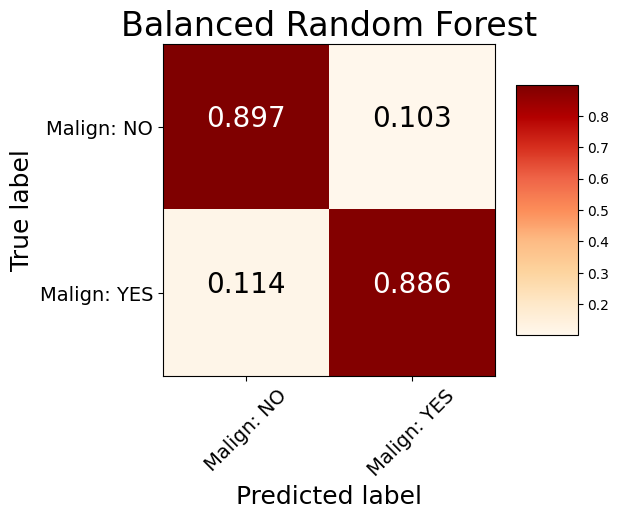

Normalized confusion matrix


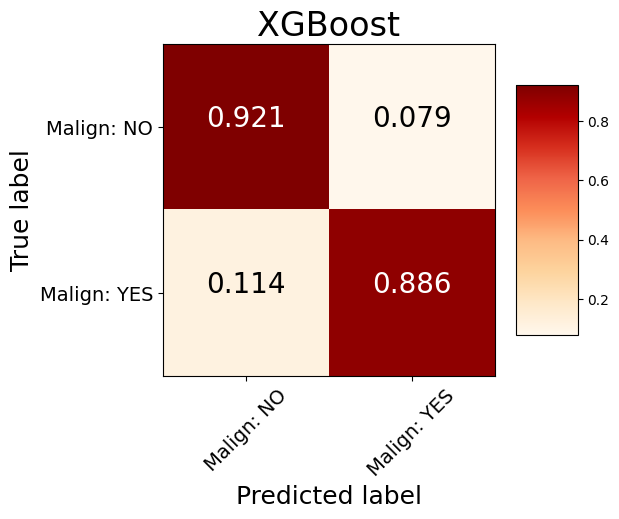

Normalized confusion matrix


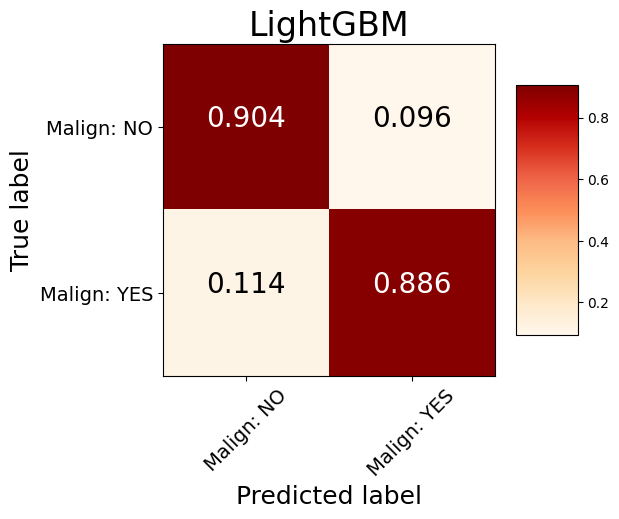

Normalized confusion matrix


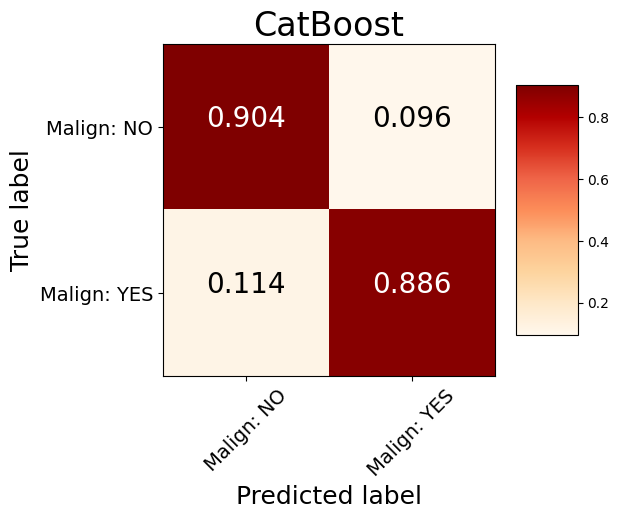

In [28]:
RECALL = 0.9
# Balanced Random Forest. Note! assuming a threshold of RECALL.
thr, _ = find_roc_threshold_tpr(model_rf_fe76_rsmpl, X1_test, y_test, RECALL)
cm = confusion_matrix(y_test, model_rf_fe76_rsmpl.predict_proba(X1_test)[:,1] > thr)
plot_confusion_matrix(cm,
                      ['Malign: NO', 'Malign: YES'],
                      normalize=True,
                      title='Balanced Random Forest',
                      cmap=plt.cm.OrRd,
                      figsize=(6,6))
##plt.savefig('images/confusion_classif.png', dpi=600)

# XGBoost. Note! assuming a threshold of RECALL.
thr, _ = find_roc_threshold_tpr(model_xgb_fe76_rsmpl, X1_test, y_test, RECALL)
cm = confusion_matrix(y_test, model_xgb_fe76_rsmpl.predict_proba(X1_test)[:,1] > thr)
plot_confusion_matrix(cm,
                      ['Malign: NO', 'Malign: YES'],
                      normalize=True,
                      title='XGBoost',
                      cmap=plt.cm.OrRd,
                      figsize=(6,6))

# LightGBM. Note! assuming a threshold of RECALL.
thr, _ = find_roc_threshold_tpr(model_lgb_fe76_rsmpl, X1_test, y_test, RECALL)
cm = confusion_matrix(y_test, model_lgb_fe76_rsmpl.predict_proba(X1_test)[:,1] > thr)
plot_confusion_matrix(cm,
                      ['Malign: NO', 'Malign: YES'],
                      normalize=True,
                      title='LightGBM',
                      cmap=plt.cm.OrRd,
                      figsize=(6,6))

# CatBoost. Note! assuming a threshold of RECALL.
thr, _ = find_roc_threshold_tpr(model_cb_fe76_rsmpl, X1_test, y_test, RECALL)
cm = confusion_matrix(y_test, model_cb_fe76_rsmpl.predict_proba(X1_test)[:,1] > thr)
plot_confusion_matrix(cm,
                      ['Malign: NO', 'Malign: YES'],
                      normalize=True,
                      title='CatBoost',
                      cmap=plt.cm.OrRd,
                      figsize=(6,6))

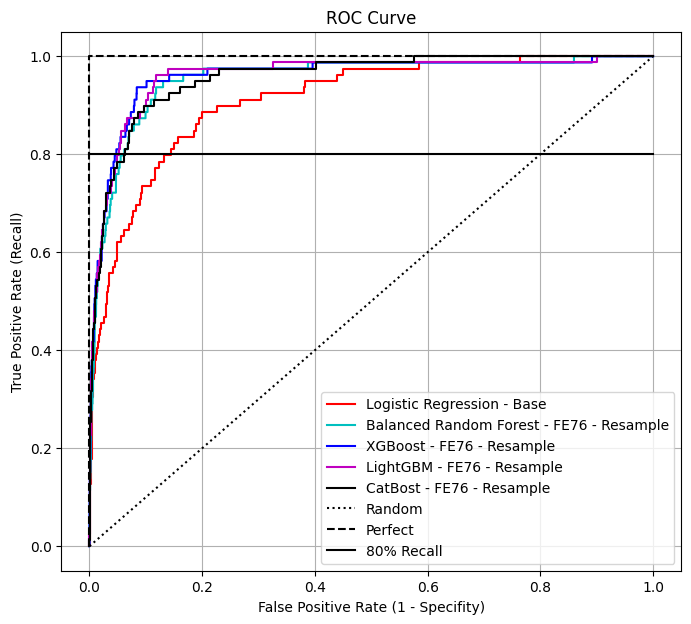

In [29]:
fpr_lr1, tpr_lr1, thr_lr1 = roc_curve(y_test, model_lr_base.predict_proba(Xb_test)[:,1])
fpr_lr2, tpr_lr2, thr_lr2 = roc_curve(y_test, model_lr_fe76.predict_proba(X1_test)[:,1])
fpr_lr3, tpr_lr3, thr_lr3 = roc_curve(y_test, model_lr_fe76_rsmpl.predict_proba(X1_test)[:,1])
fpr_lr4, tpr_lr4, thr_lr4 = roc_curve(y_test, model_rf_fe76_rsmpl.predict_proba(X1_test)[:,1])
fpr_lr5, tpr_lr5, thr_lr5 = roc_curve(y_test, model_xgb_fe76_rsmpl.predict_proba(X1_test)[:,1])
fpr_lr6, tpr_lr6, thr_lr6 = roc_curve(y_test, model_lgb_fe76_rsmpl.predict_proba(X1_test)[:,1])
fpr_lr7, tpr_lr7, thr_lr7 = roc_curve(y_test, model_cb_fe76_rsmpl.predict_proba(X1_test)[:,1])

fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot()
plt.plot(fpr_lr1, tpr_lr1, 'r-', label = 'Logistic Regression - Base')
plt.plot(fpr_lr2, tpr_lr2, 'y-', label = 'Logistic Regression - FE76')
plt.plot(fpr_lr3, tpr_lr3, 'g-', label = 'Logistic Regression - FE76 - Resample')
plt.plot(fpr_lr4, tpr_lr4, 'c-', label = 'Balanced Random Forest - FE76 - Resample')
plt.plot(fpr_lr5, tpr_lr5, 'b-', label = 'XGBoost - FE76 - Resample')
plt.plot(fpr_lr6, tpr_lr6, 'm-', label = 'LightGBM - FE76 - Resample')
plt.plot(fpr_lr7, tpr_lr7, 'k-', label = 'CatBost - FE76 - Resample')

plt.plot([0,1],[0,1],'k:',label='Random')
plt.plot([0,0,1,1],[0,1,1,1],'k--',label='Perfect')
plt.plot([0,1],[0.8,0.8],'k-',label='80% Recall')
plt.legend()
plt.title('ROC Curve')
plt.xlabel('False Positive Rate (1 - Specifity)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.show()